In [38]:
import torch
from torch import nn
import datasets as ds
from pprint import pprint
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from matplotlib import pyplot as plt

# Load dataset, and preprocess sentences to tokens

In [39]:
dataset = ds.load_dataset("glue", "sst2")

sentence_list=dataset["train"]["sentence"]
labels_list=dataset["train"]["label"]
tokenize = lambda x: x.split()
tokenized = list(map(tokenize,sentence_list))

vocab=build_vocab_from_iterator(tokenized, specials=["<UNK>"],min_freq=5)
vocab.set_default_index(0)

func = lambda x: torch.tensor(vocab(x))
integer_tokens = list(map(func,tokenized))
label_tensors = list(map(torch.tensor,labels_list))
print("A sentence from the dataset:", sentence_list[0])
print("The corresponding integer tokens:", integer_tokens[0])
print("The corresponding labels:", label_tensors[0])

test_split = len(integer_tokens)*8//10
train_tokens = integer_tokens[:test_split]
train_labels = label_tensors[:test_split]
test_tokens = integer_tokens[test_split:]
test_labels = label_tensors[test_split:]

Reusing dataset glue (C:\Users\Shlomi\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1001.27it/s]


A sentence from the dataset: hide new secretions from the parental units 
The corresponding integer tokens: tensor([ 4575,    93,     0,    36,     1,  7746, 10013])
The corresponding labels: tensor(0)


In [40]:
class MyRNNCell(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_state = torch.zeros(hidden_dim)
        self.hidden_linear= nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
        self.input_linear = nn.Linear(in_features = embed_dim, out_features = hidden_dim)
        self.activation   = nn.Tanh()

    def forward(self, one_embedded_token):
        Z1        = self.input_linear(one_embedded_token)
        Z2        = self.hidden_linear(self.hidden_state)
        Y         = Z1+Z2
        new_state = self.activation(Y)
        self.hidden_state = new_state

# Initialize the two models with same weights at the beginning - very important

If the models are initialized with diffirent weights, luck can play a role, the good model might deals better with exploding gradients than the 'bad' model, but if you run the code multiple times it can be the opposite. So to counter this I set manual seed.

In [41]:
torch.manual_seed(123)

# Basic RNN Classifier

In [42]:
# Doesn't deal with exploding gradients
class RNNClassifier(nn.Module):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__()
		self.hidden_dim = hidden_dim
		self.embedding  = nn.Embedding(len(vocab),embed_dim)
		self.rnn        = MyRNNCell(embed_dim, hidden_dim)
		self.linear     = nn.Linear(hidden_dim, 2)
		self.logsoftmax = nn.LogSoftmax(dim=0)

	def forward(self, sentence_tokens):
		self.rnn.hidden_state = torch.zeros(self.hidden_dim)
		for one_token in sentence_tokens:
			one_embedded_token = self.embedding(one_token)
			self.rnn(one_embedded_token)

		feature_extractor_output = self.rnn.hidden_state
		class_scores       = self.linear(feature_extractor_output)
		logprobs           = self.logsoftmax(class_scores)
		return logprobs

# Modified RNN classifier - stop at recursion

In [43]:
# Deal with exploding gradients
class MyRNNClassifier(nn.Module):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__()
		self.hidden_dim = hidden_dim
		self.embedding  = nn.Embedding(len(vocab),embed_dim)
		self.rnn        = MyRNNCell(embed_dim, hidden_dim)
		self.linear     = nn.Linear(hidden_dim, 2)
		self.logsoftmax = nn.LogSoftmax(dim=0)

	def forward(self, sentence_tokens, t):
		self.rnn.hidden_state = torch.zeros(self.hidden_dim)
		for i, one_token in enumerate(sentence_tokens):
			T = len(sentence_tokens)

			if (T-t) > 0 and i > (T-t):
				self.rnn.requires_grad_(False) # Stop backpropagation, for the rest of the words of this spesific sentence
			one_embedded_token = self.embedding(one_token)
			self.rnn(one_embedded_token)
		
		self.rnn.requires_grad_(True) # Continue backpropagation for the rest of the samples (sentences)

		feature_extractor_output = self.rnn.hidden_state
		class_scores       = self.linear(feature_extractor_output)
		logprobs           = self.logsoftmax(class_scores)
		return logprobs

# Define the good/bad models

In [44]:
# Does not deal with exploding gradients
bad_model = RNNClassifier(10,10)
bad_model_optimizer = torch.optim.AdamW(bad_model.parameters())

# Deal with exploding gradients
good_model = MyRNNClassifier(10,10)
good_model_optimizer = torch.optim.AdamW(good_model.parameters())

In [45]:
# def my_backward_hook(module, grad_input, grad_output):
# 	print("grad_input:", grad_input)
# 	print("grad_output:", grad_output)

# bad_model.register_full_backward_hook(my_backward_hook)

In [46]:
def iterate_one_sentence(model, optimizer, tokens, label, train_flag, is_good_model, t):
	if train_flag:
		if is_good_model:
			model.train()  
			optimizer.zero_grad()
			y_model=model(tokens, t)
			loss= -y_model[label] #Cross Entropy
			loss.backward()
			optimizer.step()
		else:
			model.train()  
			optimizer.zero_grad()
			y_model=model(tokens)
			loss= -y_model[label] #Cross Entropy
			loss.backward()
			optimizer.step()
	else:
		model.eval()
		y_model=model(tokens)
		model.train()
	with torch.no_grad():
		predicted_labels = y_model.argmax()
		success = (predicted_labels == label)
	return success

In [47]:
BATCH_SIZE = 100
EPOCHES = 10

def my_training_func(model, optimizer, is_good_model, t = 0):
	#overfit a small batch to check if learning _can_ occur
	if is_good_model:
		print("Good model - train start")
	else:
		print("Bad model - train start")

	parameters = list(model.parameters())
	avg_grad_norms = torch.zeros(EPOCHES)
	for epoch in range(EPOCHES):
		correct_predictions = torch.tensor([0.])
		grad_norm_temp = torch.zeros(BATCH_SIZE)
		for idx in range(BATCH_SIZE):
			correct_predictions += iterate_one_sentence(model, optimizer, train_tokens[idx], train_labels[idx], True, is_good_model, t)
			norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
			grad_norm_temp[idx] = torch.max(torch.stack(norms))
		avg_grad_norms[epoch] = grad_norm_temp.mean()
		
		acc=correct_predictions/BATCH_SIZE
		if epoch%3==0:
			print("Epoch",epoch," acc:",acc.item())
	return avg_grad_norms

# Train the models and compare (with/without dealing with exploding gradients)

In [48]:
t = 6

good_avg_grad_norms = my_training_func(good_model, good_model_optimizer, True, t)
bad_avg_grad_norms = my_training_func(bad_model, bad_model_optimizer, False)

Good model - train start
Epoch 0  acc: 0.47999998927116394
Epoch 3  acc: 0.6299999952316284
Epoch 6  acc: 0.699999988079071
Epoch 9  acc: 0.7900000214576721
Bad model - train start
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([ 0., -1.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([ 0., -1.]),)
grad_input: (None,)
grad_output: (tensor([ 0., -1.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([ 0., -1.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0.]),)
grad_input: (None,)
grad_output: (tensor([-1.,  0

# Plot exploding gradients (inf norm)

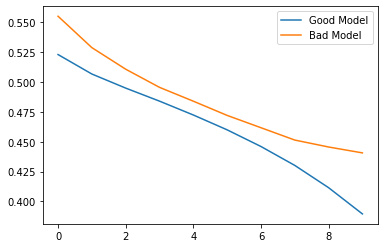

In [49]:
plt.figure()
plt.plot(good_avg_grad_norms, label="Good Model")
plt.plot(bad_avg_grad_norms, label="Bad Model")
plt.legend()
plt.show()

# Proof it works

In [50]:
sentence = "i am studying deep learning at the open university"
# tokens = tokenize(sentence)
# tokenized = list(map(tokenize, [sentence]))

# i = 178
# sentence = sentence_list[i]
# label = labels_list[i]
# print(sentence, label)


tokenize = lambda x: x.split()
tokenized = list(map(tokenize,[sentence]))

# vocab=build_vocab_from_iterator(tokenized, specials=["<UNK>"],min_freq=5)
# vocab.set_default_index(0)

func = lambda x: torch.tensor(vocab(x))
integer_tokens = list(map(func,tokenized))
